# ChArUco diamond marker detection for extrinsic calibration

* https://docs.opencv.org/4.x/d5/d07/tutorial_charuco_diamond_detection.html
* https://docs.opencv.org/4.8.0/d9/d6a/group__aruco.html

Suppose we capture a ChAruco diamond marker by multiple cameras, and detect the corner in each image as corresponding points for extrinsic calibration.  The below demonstrates how to use `cv2.aruco.detectCharucoDiamond()` for this.

## Libraries

In [1]:
%matplotlib notebook
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pycalib.plot import plotCamera
from pycalib.calib import lookat


## ChArUco diamond marker

Print the following pattern on a board (or show this on your flat panel display), and capture it by your camera.

<IPython.core.display.Javascript object>


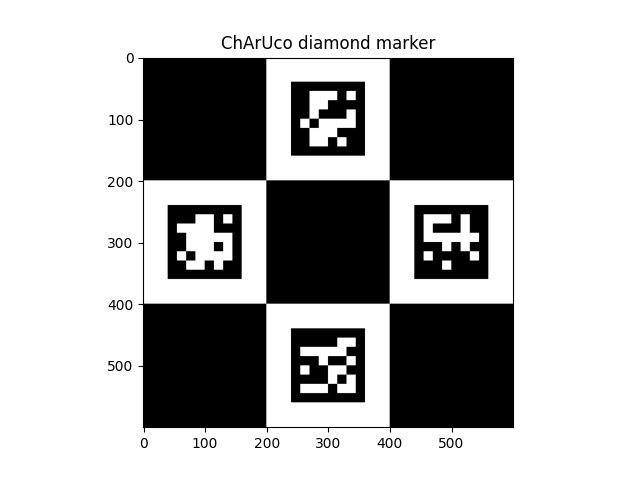

True

In [2]:
square_length = 200
marker_length = 120
diamond_marker_ids = (45,68,28,74) # any 4 markers can define a diamond
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
board = cv2.aruco.drawCharucoDiamond(aruco_dict, diamond_marker_ids, square_length, marker_length)

plt.figure()
plt.imshow(board, cmap='gray')
plt.title('ChArUco diamond marker')
plt.show()

# save this as an image for printing / displaying
cv2.imwrite("output_charuco_diamond.png", board)


## Captured images

<IPython.core.display.Javascript object>


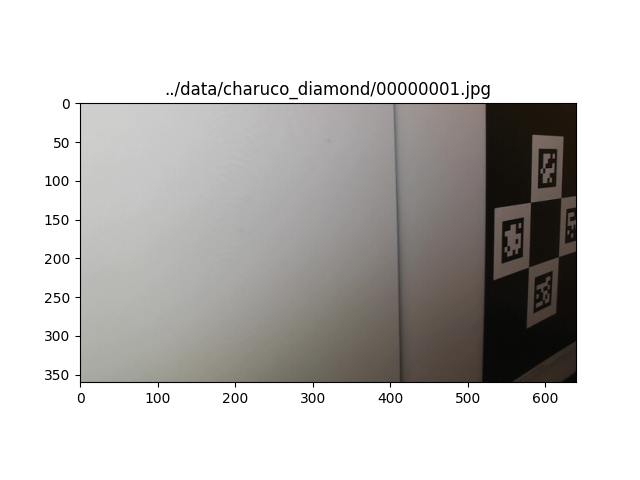

<IPython.core.display.Javascript object>


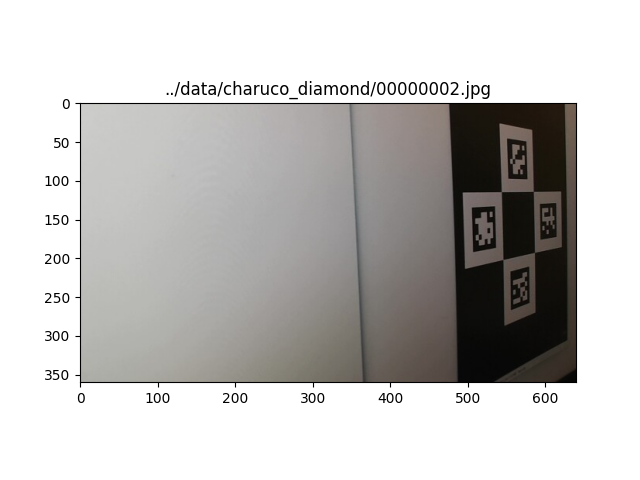

In [3]:
imgs = []
for i in sorted(glob('../data/charuco_diamond/0*.jpg')):
    im = cv2.imread(i)
    imgs.append(im)
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(i)
    plt.show()

## ChArUco diamond detection

We can observe that the diamond marker can be found only if four markers are visible.  Use the ZOOM button in the plot to double-check that the corner position (green box) is sub-pixel accurate.

Four Aruco markers are not found. Detected IDs are: [45 74 68]


<IPython.core.display.Javascript object>


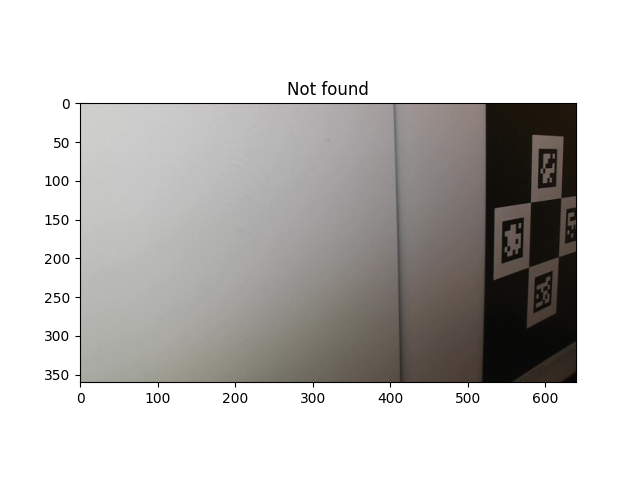

<IPython.core.display.Javascript object>


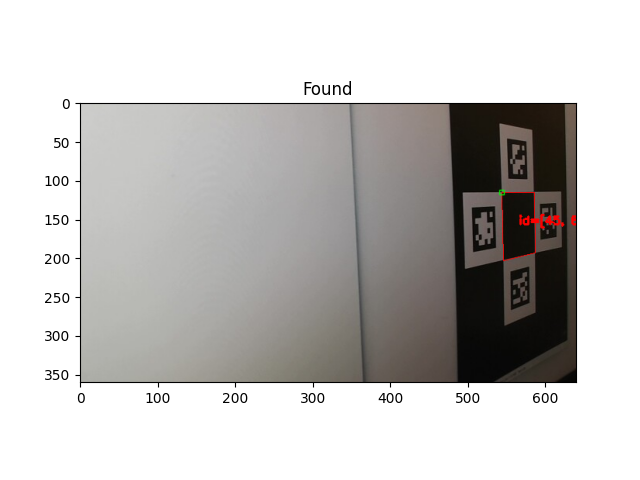

In [4]:
def detect_charuco_diamond(gray, aruco_dict, square_length, marker_length, target_diamond_ids):
    # detect Aruco
    detected_corners, detected_ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    if detected_ids is None:
        print('Aruco markers are not found')
        return None, None
    if len(detected_ids) < 4:
        print(f'Four Aruco markers are not found. Detected IDs are: {detected_ids.flatten()}')
        return None, None
    
    # detect Aruco diamonds
    detected_diamond_corners, detected_diamond_ids = cv2.aruco.detectCharucoDiamond(gray, detected_corners, detected_ids, square_length / marker_length)
    if detected_diamond_ids is None:
        print('Diamond markers are not found')
        return None, None

    # check if the detected one is the target
    target_diamond_ids = np.array(target_diamond_ids).reshape((-1, 1, 4)) # detectCharucoDiamond returns (N, 1, 4) array
    ret_corners = []
    ret_ids = []
    for tdi in target_diamond_ids:
        found = False
        for ddc, ddi in zip(detected_diamond_corners, detected_diamond_ids):
            if np.array_equal(tdi, ddi):
                ret_corners.append(ddc)
                ret_ids.append(ddi)
                found = True
                break
        if not found:
            print(f'Diamond {tdi.flatten()} not found')
            return None, None

    return np.array(ret_corners), np.array(ret_ids)


for im in imgs:
    bgr = im.copy()
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    detected_diamond_corners, detected_diamond_ids = detect_charuco_diamond(gray, aruco_dict, square_length, marker_length, diamond_marker_ids)
    cv2.aruco.drawDetectedDiamonds(bgr, detected_diamond_corners, detected_diamond_ids)
    plt.figure()
    plt.imshow(bgr[:,:,::-1])
    if detected_diamond_ids is not None:
        plt.title('Found')
    else:
        plt.title(f'Not found')
    plt.show()

## ChAruco diamond detection from rotated and flipped images

The diamond corner can be found at the rotated position correctly, but not found in flipped images.  This is because image flipping invalidates each of the Aruco markers.


Aruco markers are not found


<IPython.core.display.Javascript object>


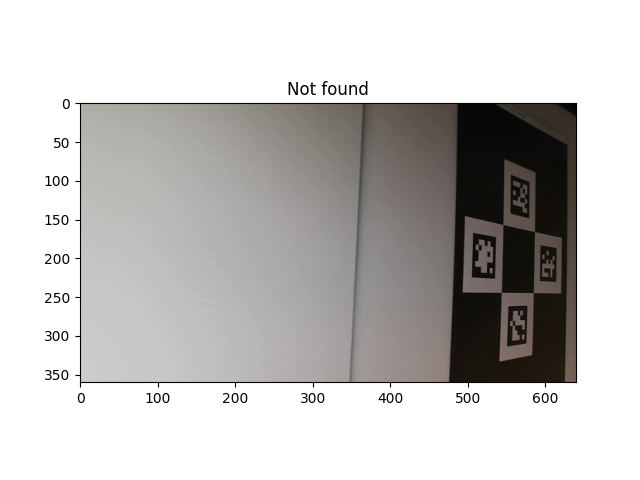

Aruco markers are not found


<IPython.core.display.Javascript object>


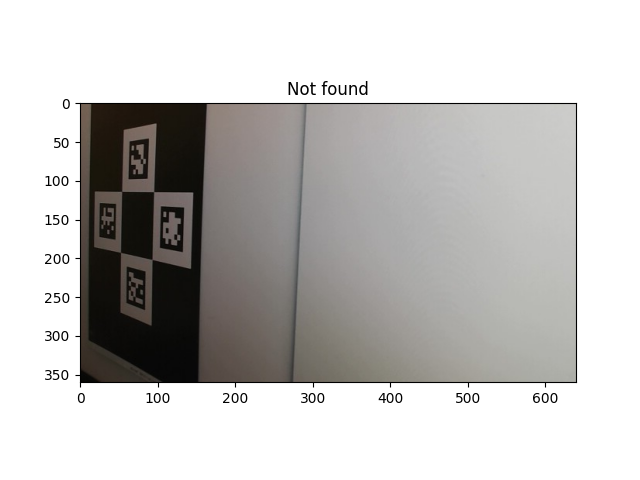

Aruco markers are not found


<IPython.core.display.Javascript object>


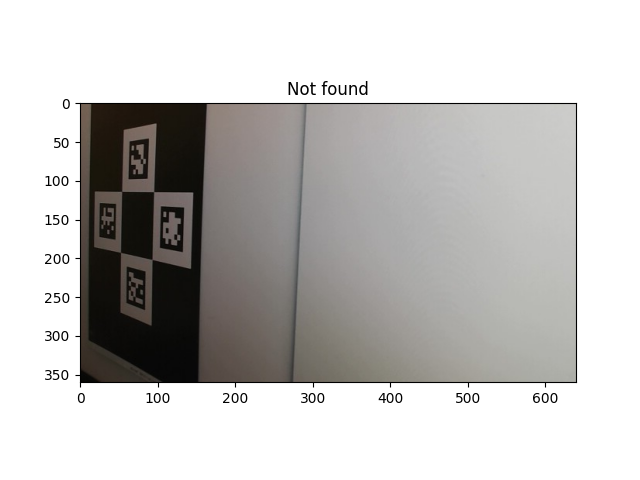

<IPython.core.display.Javascript object>

In [5]:
test_images = [cv2.flip(imgs[1], 0), # flip ud
               cv2.flip(imgs[1], 1), # flip lr
               cv2.flip(imgs[1], 2), # flip ud+lr
               cv2.rotate(imgs[1], cv2.ROTATE_180), # rotate
              ]

for im in test_images:
    bgr = im.copy()
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    detected_diamond_corners, detected_diamond_ids = detect_charuco_diamond(gray, aruco_dict, square_length, marker_length, diamond_marker_ids)
    cv2.aruco.drawDetectedDiamonds(bgr, detected_diamond_corners, detected_diamond_ids)
    plt.figure()
    plt.imshow(bgr[:,:,::-1])
    if detected_diamond_ids is not None:
        plt.title('Found')
    else:
        plt.title(f'Not found')
    plt.show()

## Pose estimation

If we have the intrinsic parameter of the camera, we can also estimte the camera pose w.r.t. the marker.
Though OpenCV provides `cv2.aruco.estimatePoseSingleMarkers()`, it is marked as "deprecated".  We can use `cv2.solvePnP()` instead.